# Clustering microbiome data using HULK sketches

***

## Commands used to download the data

```bash
#!/usr/bin/env bash
# This script downloads the CAMI data, just pipe it the samples you want (Airways, Oral etc.)

dataset=$1
mkdir $1 && cd $_
echo "downloading the ${1} read data from CAMI"
URL="https://openstack.cebitec.uni-bielefeld.de:8080/swift/v1/CAMI_${1}/"
echo "url: ${URL}"

# get the file list
curl ${URL} | grep 'fq.gz' >> reads.list

# download each file in turn and store in sequentially labelled fastqs
COUNTER=1
while read -r line
    do
    download=${URL}${line}
    curl ${download} -o ${COUNTER}.fastq.gz
    COUNTER=$((COUNTER + 1))
    echo "downloaded ${download} and saved to ${COUNTER}.fastq.gz"
    done < reads.list
echo "finished."
```

## Commands used to generate the sketches

``` bash
#!/usr/bin/env bash

# This script automates the submission of HULK jobs to the Scafell cluster.
# It will run HULK on each set of CAMI short read samples, storing the sketches for each in a separate directory

# PARAMETERS
## general
CPU=12
QUEUE=scafellpikeSKL
WALL=0:20
SAMPLES=( "Airways" "Gastrointestinal_tract" "Oral" "Skin" "Urogenital_tract" )
## hulk
K=21
S=512

# JOB SUBMISSION
mkdir illumina-hulk-sketches-k${K}-s${S} && cd $_
counter=0
## the cami files are sequentially ordered in each download (1-10 = pacbio, 11-20 = short read)
for i in {11..20}
  do
  for name in "${SAMPLES[@]}"
    do
    outfile=${name}.${i}
    CMD="gunzip -c ../${name}/${i}.fastq.gz | hulk sketch -p ${CPU} -s ${S} -k ${K} -o ${outfile}"
    echo $CMD | bsub -n ${CPU} -R "span[ptile=${CPU}]" -W ${WALL} -q ${QUEUE}
  done
done
```

## Command used to generate pairwise jaccard similarity matrix from the sketches


```
# This will leave us with a file called `cami.k21s512.js-matrix.csv` which we then use in this analysis.
hulk smash -o cami.k21s512 --jsMatrix
```

In [20]:
# Pandas for managing datasets
import pandas as pd

# Re for cleaning up data headers
import re

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
sns.set()

In [21]:
# Read dataset
df = pd.read_csv('data/cami.k21s512.js-matrix.csv')

In [22]:
# Rename columns to just body site
df = df.rename(columns=lambda x: re.sub('.\d+.sketch','',x))
df.head()

,Airways,Urogenital_tract,Urogenital_tract,Airways,Gastrointestinal_tract,Gastrointestinal_tract,Oral,Skin,Gastrointestinal_tract,Oral,...,Oral,Skin,Skin,Skin,Airways,Airways,Gastrointestinal_tract,Gastrointestinal_tract,Gastrointestinal_tract,Urogenital_tract
0,1.00,0.83,0.87,0.92,0.89,0.89,0.86,0.89,0.87,0.85,...,0.85,0.89,0.91,0.90,0.92,0.92,0.86,0.88,0.88,0.87
1,0.83,1.00,0.85,0.85,0.87,0.86,0.83,0.79,0.83,0.81,...,0.79,0.82,0.84,0.81,0.85,0.83,0.83,0.85,0.86,0.83
2,0.87,0.85,1.00,0.88,0.90,0.89,0.87,0.84,0.86,0.84,...,0.84,0.86,0.89,0.87,0.88,0.86,0.87,0.88,0.89,0.93
3,0.92,0.85,0.88,1.00,0.90,0.90,0.87,0.88,0.86,0.84,...,0.85,0.89,0.92,0.89,0.91,0.92,0.88,0.90,0.91,0.88
4,0.89,0.87,0.90,0.90,1.00,0.92,0.90,0.86,0.88,0.85,...,0.87,0.88,0.91,0.88,0.91,0.88,0.89,0.90,0.90,0.87


In [23]:
# Check number of samples for each body site (there should be 10 each, apart from UGT with 8)
df.columns.value_counts()

Oral                      10
Airways                   10
Skin                      10
Gastrointestinal_tract    10
Urogenital_tract           8
dtype: int64

In [24]:
# Get the body site labels
sites = pd.Series(df.columns)

In [25]:
# Create a palette to identify the body sites
sites_pal = sns.color_palette("husl", len(sites.unique()))

In [26]:
# Create a lookup table to link palette to body site
lut = dict(zip(sites.unique(), sites_pal))
lut

{'Airways': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'Urogenital_tract': (0.6804189127793346,
  0.6151497514677574,
  0.19405452111445337),
 'Gastrointestinal_tract': (0.20125317221201128,
  0.6907920815379025,
  0.47966761189275336),
 'Oral': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 'Skin': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522)}

In [27]:
# Convert the palette to vectors that will be drawn on the side of the matrix
colours = sites.map(lut)

Text(0.5,0.98,'CAMI metagenome hulk sketches clustered by Jaccard Similarity')

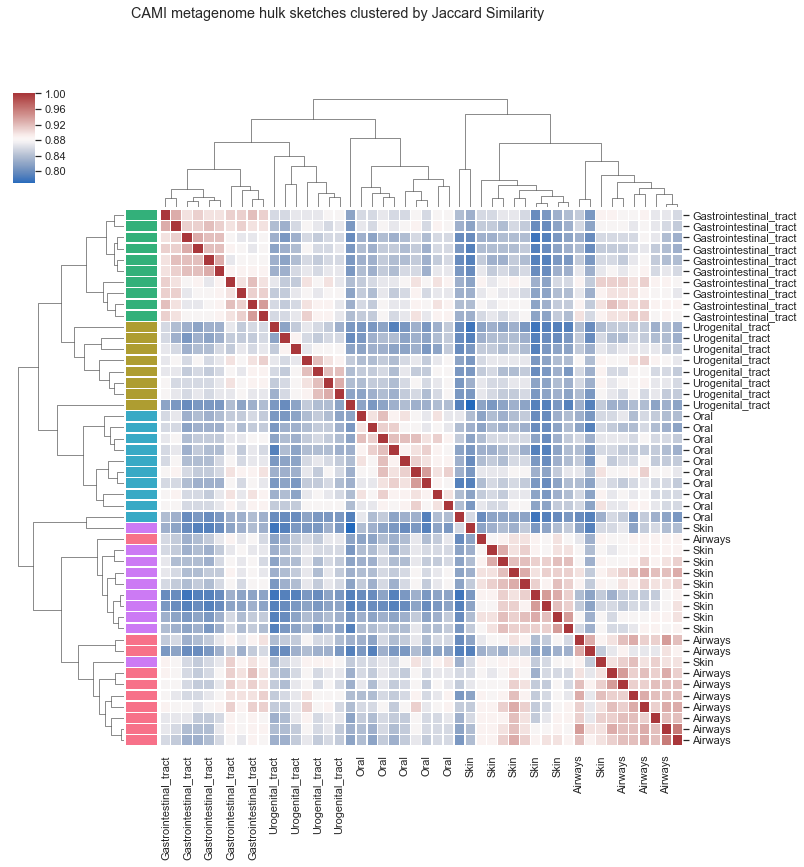

In [28]:
g = sns.clustermap(df, method='complete', metric='correlation', cmap="vlag",
                   row_colors=colours, row_cluster=True, col_cluster=True, yticklabels=df.columns,
                   linewidths=.50, figsize=(12, 12))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("CAMI metagenome hulk sketches clustered by Jaccard Similarity")

for site in *; do for i in ./${site}/*.gz; do filename=${i%%.fastq.gz}; echo "${site}.${filename##*/}": `pwd $i`/${site}/${i##*/} >> simka-input.list; done; done

./bin/simka -count-file job_count.sh -merge-file job_merge.sh -count-cmd bsub -merge-cmd bsub -kmer-size 21 -complex-dist -in simka-input.list -out RESULTS -out-tmp tmp-out